# Assignment 2 - Q-Learning and Expected Sarsa

Welcome to Course 2 Programming Assignment 2. In this notebook, you will:

1. Implement Q-Learning with $\epsilon$-greedy action selection
2. Implement Expected Sarsa with $\epsilon$-greedy action selection
3. Investigate how these two algorithms behave on Cliff World (described on page 132 of the textbook)

We will provide you with the environment and infrastructure to run an experiment (called the experiment program in RL-Glue). This notebook will provide all the code you need to run your experiment and visualise learning performance.

This assignment will be graded automatically by comparing the behavior of your agent to our implementations of Expected Sarsa and Q-learning. The random seed will be set to avoid different behavior due to randomness. We will highlight the functions you have to use for generating random samples and the number of times these functions should be called. 

## Packages

You will need the following libraries for this assignment. We are using:
1. numpy: the fundamental package for scientific computing with Python.
2. scipy: a Python library for scientific and technical computing.
3. matplotlib: library for plotting graphs in Python.
4. RL-Glue: library for reinforcement learning experiments.

DO NOT IMPORT OTHER LIBRARIES - This will break the autograder.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import sem

from rl_glue import RLGlue
from agent import BaseAgent
import cliffworld_env

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

## Q-Learning

In this section you will implement and test a Q-Learning agent with $\epsilon$-greedy action selection (Section 6.5 in the textbook). 

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [3]:
# -----------
# Graded Cell
# -----------

class QLearningAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, observation):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            observation (int): the state observation from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        state = observation
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (int): the state observation from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        state = observation
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update
        # --------------------------
        q = self.q[self.prev_state][self.prev_action]
        target = reward + self.discount * max(current_q) 
        q += self.step_size * (target - q)
        self.q[self.prev_state][self.prev_action] = q
        # --------------------------
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        # --------------------------
        q = self.q[self.prev_state][self.prev_action]
        target = reward 
        q += self.step_size * (target - q)
        self.q[self.prev_state][self.prev_action] = q
        # --------------------------
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

### Test

Run the cells below to test the implemented methods. The output of each cell should match the expected output.

Note that passing this test does not guarantee correct behavior on the Cliff World.

In [4]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

np.random.seed(0)

agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent = QLearningAgent()
agent.agent_init(agent_info)
action = agent.agent_start(0)

expected_values = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])

assert np.all(agent.q == expected_values)
assert action == 1

# reset the agent
agent.agent_init(agent_info)

action = agent.agent_start(0)
assert action == 1

action = agent.agent_step(2, 1)
assert action == 3

action = agent.agent_step(0, 0)
assert action == 1

expected_values = np.array([
    [0.,  0.2,  0.,  0.  ],
    [0.,  0.,   0.,  0.02],
    [0.,  0.,   0.,  0.  ],
])
assert np.all(np.isclose(agent.q, expected_values))

# reset the agent
agent.agent_init(agent_info)

action = agent.agent_start(0)
assert action == 1

action = agent.agent_step(2, 1)
assert action == 3

agent.agent_end(1)

expected_values = np.array([
    [0.,  0.2, 0.,  0. ],
    [0.,  0.,  0.,  0.1],
    [0.,  0.,  0.,  0. ],
])
assert np.all(np.isclose(agent.q, expected_values))

# Expected Sarsa

In this section you will implement an Expected Sarsa agent with $\epsilon$-greedy action selection (Section 6.6 in the textbook). 

### Implementation

Your job is to implement the updates in the methods agent_step and agent_end. We provide detailed comments in each method describing what your code should do.

In [5]:
# -----------
# Graded Cell
# -----------

class ExpectedSarsaAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

        
    def agent_start(self, observation):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            observation (int): the state observation from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        state = observation
        current_q = self.q[state, :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (int): the state observation from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        state = observation
        current_q = self.q[state,:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        # Perform an update
        # --------------------------
        pi = np.full(current_q.size, self.epsilon / self.num_actions)
        pi[action] += 1-self.epsilon
        assert np.isclose(np.sum(pi), 1) == True
        
        expected_q = np.sum(np.dot(current_q, pi))
        
        prev_q = self.q[self.prev_state][self.prev_action]                
        target = reward + self.discount * expected_q
        prev_q += self.step_size * (target - prev_q)
        self.q[self.prev_state][self.prev_action] = prev_q        
        # --------------------------
        
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        # Perform the last update in the episode
        # --------------------------
        prev_q = self.q[self.prev_state][self.prev_action]                
        target = reward
        prev_q += self.step_size * (target - prev_q)
        self.q[self.prev_state][self.prev_action] = prev_q
        # --------------------------
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

### Test

Run the cells below to test the implemented methods. The output of each cell should match the expected output.

Note that passing this test does not guarantee correct behavior on the Cliff World.

In [6]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {"num_actions": 4, "num_states": 3, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent = ExpectedSarsaAgent()
agent.agent_init(agent_info)

action = agent.agent_start(0)
assert action == 1

expected_values = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])
assert np.all(agent.q == expected_values)

# ---------------
# test agent step
# ---------------

action = agent.agent_step(2, 1)
assert action == 3

action = agent.agent_step(0, 0)
assert action == 1

expected_values = np.array([
    [0, 0.2, 0, 0],
    [0, 0, 0, 0.0185],
    [0, 0, 0, 0],
])
assert np.all(np.isclose(agent.q, expected_values))

# --------------
# test agent end
# --------------

agent.agent_end(1)

expected_values = np.array([
    [0, 0.28, 0, 0],
    [0, 0, 0, 0.0185],
    [0, 0, 0, 0],
])
assert np.all(np.isclose(agent.q, expected_values))

# Solving the Cliff World

We described the Cliff World environment in the video "Expected Sarsa in the Cliff World" in Lesson 3. This is an undiscounted episodic task and thus we set $\gamma$=1. The agent starts in the bottom left corner of the gridworld below and takes actions that move it in the four directions. Actions that would move the agent off of the cliff incur a reward of -100 and send the agent back to the start state. The reward for all other transitions is -1. An episode terminates when the agent reaches the bottom right corner. 

<img src="cliffworld.png" alt="Drawing" style="width: 600px;"/>


Using the experiment program in the cell below we now compare the agents on the Cliff World environment and plot the sum of rewards during each episode for the two agents.

The result of this cell will be graded. If you make any changes to your algorithms, you have to run this cell again before submitting the assignment.

100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


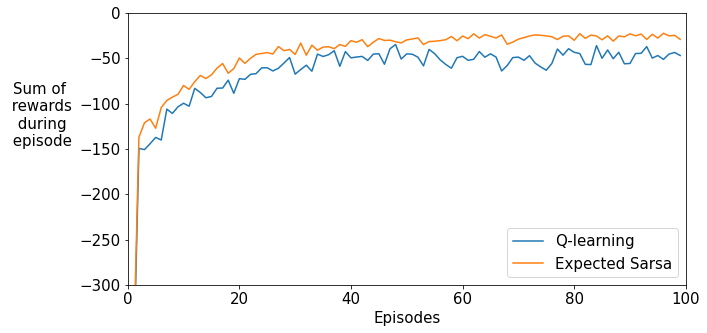

In [7]:
# ---------------
# Discussion Cell
# ---------------
np.random.seed(0)

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0}
env_info = {}
num_runs = 100 # The number of runs
num_episodes = 100 # The number of episodes in each run

for algorithm in ["Q-learning", "Expected Sarsa"]:
    all_reward_sums[algorithm] = []
    all_state_visits[algorithm] = []
    for run in tqdm(range(num_runs)):
        agent_info["seed"] = run
        rl_glue = RLGlue(env, agents[algorithm])
        rl_glue.rl_init(agent_info, env_info)

        reward_sums = []
        state_visits = np.zeros(48)
        last_episode_total_reward = 0
        for episode in range(num_episodes):
            if episode < num_episodes - 10:
                # Runs an episode
                rl_glue.rl_episode(10000) 
            else: 
                # Runs an episode while keeping track of visited states
                state, action = rl_glue.rl_start()
                state_visits[state] += 1
                is_terminal = False
                while not is_terminal:
                    reward, state, action, is_terminal = rl_glue.rl_step()
                    state_visits[state] += 1
                
            # Errata: https://www.coursera.org/learn/sample-based-learning-methods/discussions/weeks/3/threads/1pyi_U_VEeu_fworF2OESQ/replies/OAuFjlk1EeubIRLAdwTdJQ    
#             reward_sums.append(rl_glue.rl_return() - last_episode_total_reward)
            reward_sums.append(rl_glue.rl_return())
            last_episode_total_reward = rl_glue.rl_return()
            
        all_reward_sums[algorithm].append(reward_sums)
        all_state_visits[algorithm].append(state_visits)
        
# plot results
for algorithm in ["Q-learning", "Expected Sarsa"]:
    plt.plot(np.mean(all_reward_sums[algorithm], axis=0), label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,100)
# plt.ylim(-30,0)
plt.ylim(-300,0)
plt.legend()
plt.show()

To see why these two agents behave differently, let's inspect the states they visit most. Run the cell below to generate plots showing the number of timesteps that the agents spent in each state over the last 10 episodes.

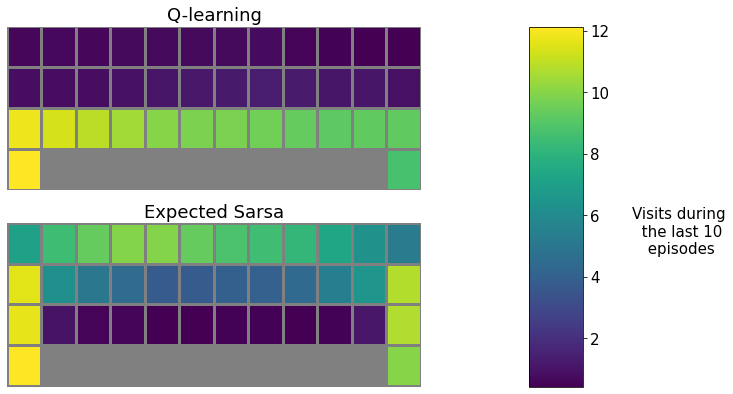

In [8]:
# ---------------
# Discussion Cell
# ---------------

for algorithm, position in [("Q-learning", 211), ("Expected Sarsa", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
    
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()

The Q-learning agent learns the optimal policy, one that moves along the cliff and reaches the goal in as few steps as possible. However, since the agent does not follow the optimal policy and uses $\epsilon$-greedy exploration, it occasionally falls off the cliff. The Expected Sarsa agent takes exploration into account and follows a safer path.


Previously we used a fixed step-size of 0.5 for the agents. What happens with other step-sizes? Does this difference in performance persist?

In the next experiment we will try 10 different step-sizes from 0.1 to 1.0 and compare the sum of rewards per episode averaged over the first 100 episodes (similar to the interim performance curves in Figure 6.3 of the textbook). Shaded regions show standard errors.

This cell takes around 10 minutes to run. The result of this cell will be graded. If you make any changes to your algorithms, you have to run this cell again before submitting the assignment.

100%|██████████| 2400/2400 [09:05<00:00,  4.40it/s]


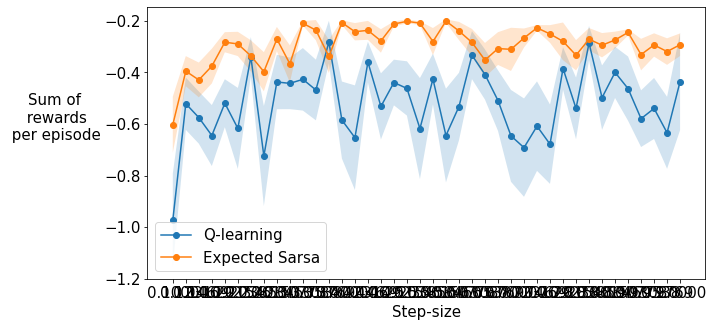

In [9]:
# ---------------
# Discussion Cell
# ---------------
from itertools import product

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,40)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 30
num_episodes = 100
all_reward_sums = {}

algorithms = ["Q-learning", "Expected Sarsa"]
cross_product = list(product(algorithms, step_sizes, range(num_runs)))
for algorithm, step_size, run in tqdm(cross_product):
    if (algorithm, step_size) not in all_reward_sums:
        all_reward_sums[(algorithm, step_size)] = []

    agent_info["step_size"] = step_size
    agent_info["seed"] = run
    rl_glue = RLGlue(env, agents[algorithm])
    rl_glue.rl_init(agent_info, env_info)

    last_episode_total_reward = 0
    for episode in range(num_episodes):
        rl_glue.rl_episode(0)
    all_reward_sums[(algorithm, step_size)].append(rl_glue.rl_return()/num_episodes)
        

for algorithm in ["Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

Expected Sarsa shows an advantage over Q-learning in this problem across a wide range of step-sizes.

Congratulations! Now you have:

- implemented Q-Learning with $\epsilon$-greedy action selection
- implemented Expected Sarsa with $\epsilon$-greedy action selection
- investigated the behavior of these two algorithms on Cliff World